# UK Mobile Network Signal Data Visualisation

This generates a visualisation of 2G/3G/4G mobile signal data on UK rail lines from a dataset gathered by Ofcom.

The lovely [Datashader](https://datashader.org/) is used to render it.

The data is available on [Ofcom's open data page](https://www.ofcom.org.uk/research-and-data/data/opendata) under "Spectrum Open Data". Note that each file is around 1.5GB in size, for a total size of around 4GB.

In [2]:
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import colorcet
from PIL import Image, ImageFont, ImageDraw

In [4]:
%%time

# Load the data as Pandas data frames. This takes a while.
gsm = pd.read_csv('./gsm-jun18tojun19-yt.csv')
umts = pd.read_csv('./umts-jun18tojun19-yt.csv')
lte = pd.read_csv('./lte-jun18tojun19-yt.csv')

CPU times: user 37.7 s, sys: 2.92 s, total: 40.6 s
Wall time: 40.7 s


In [5]:
# Correct an apparently misnamed column in the LTE dataset.
lte['ptotal'] = lte['total_power']

In [6]:
# Fetch the boundaries and calculate the aspect ratio (Datashader doesn't do this automatically).
# We're using the OS grid coordinates provided in the data here as it's a better projection than lat/lon.

border = 50000 # 50km border
max_x, min_x = np.max(gsm['eastings']) + border, np.min(gsm['eastings']) - border
max_y, min_y = np.max(gsm['northings']) + border, np.min(gsm['northings']) - border

aspect = (max_y - min_y) / (max_x - min_x)

In [7]:
def make_plot(data):
    """ Render a single dataset and return a Datashader image. """
    width = 1000
    cvs = ds.Canvas(plot_width=width, 
                    plot_height=int(width * aspect), 
                    x_range=(min_x, max_x), 
                    y_range=(min_y, max_y))
    
    # Plot the points here, using the maximum received signal strength if we
    # have multiple measurements in one pixel.
    agg = cvs.points(data, 'eastings', 'northings', ds.max('ptotal'))
    
    # Shade using the BMY pallete from colorcet and spread the data a bit to improve visibility.
    return tf.set_background(tf.spread(tf.shade(agg, cmap=colorcet.bmy), px=1), 'black')

In [9]:
def draw_text(img, text, x, y, size=30, face="Regular", color=(230,230,230)):
    """ Helper to draw text labels using PIL. """
    # This font path assumes you're using a Mac with Open Sans installed.
    fnt = ImageFont.truetype(f"~/Library/Fonts/OpenSans-{face}.ttf", size)
    d = ImageDraw.Draw(img)
    w, h = d.textsize(text, fnt)
    x -= w // 2
    h -= h // 2
    d.text((x, y), text, font=fnt, fill=color)
    return img

CPU times: user 2.07 s, sys: 579 ms, total: 2.65 s
Wall time: 2.65 s


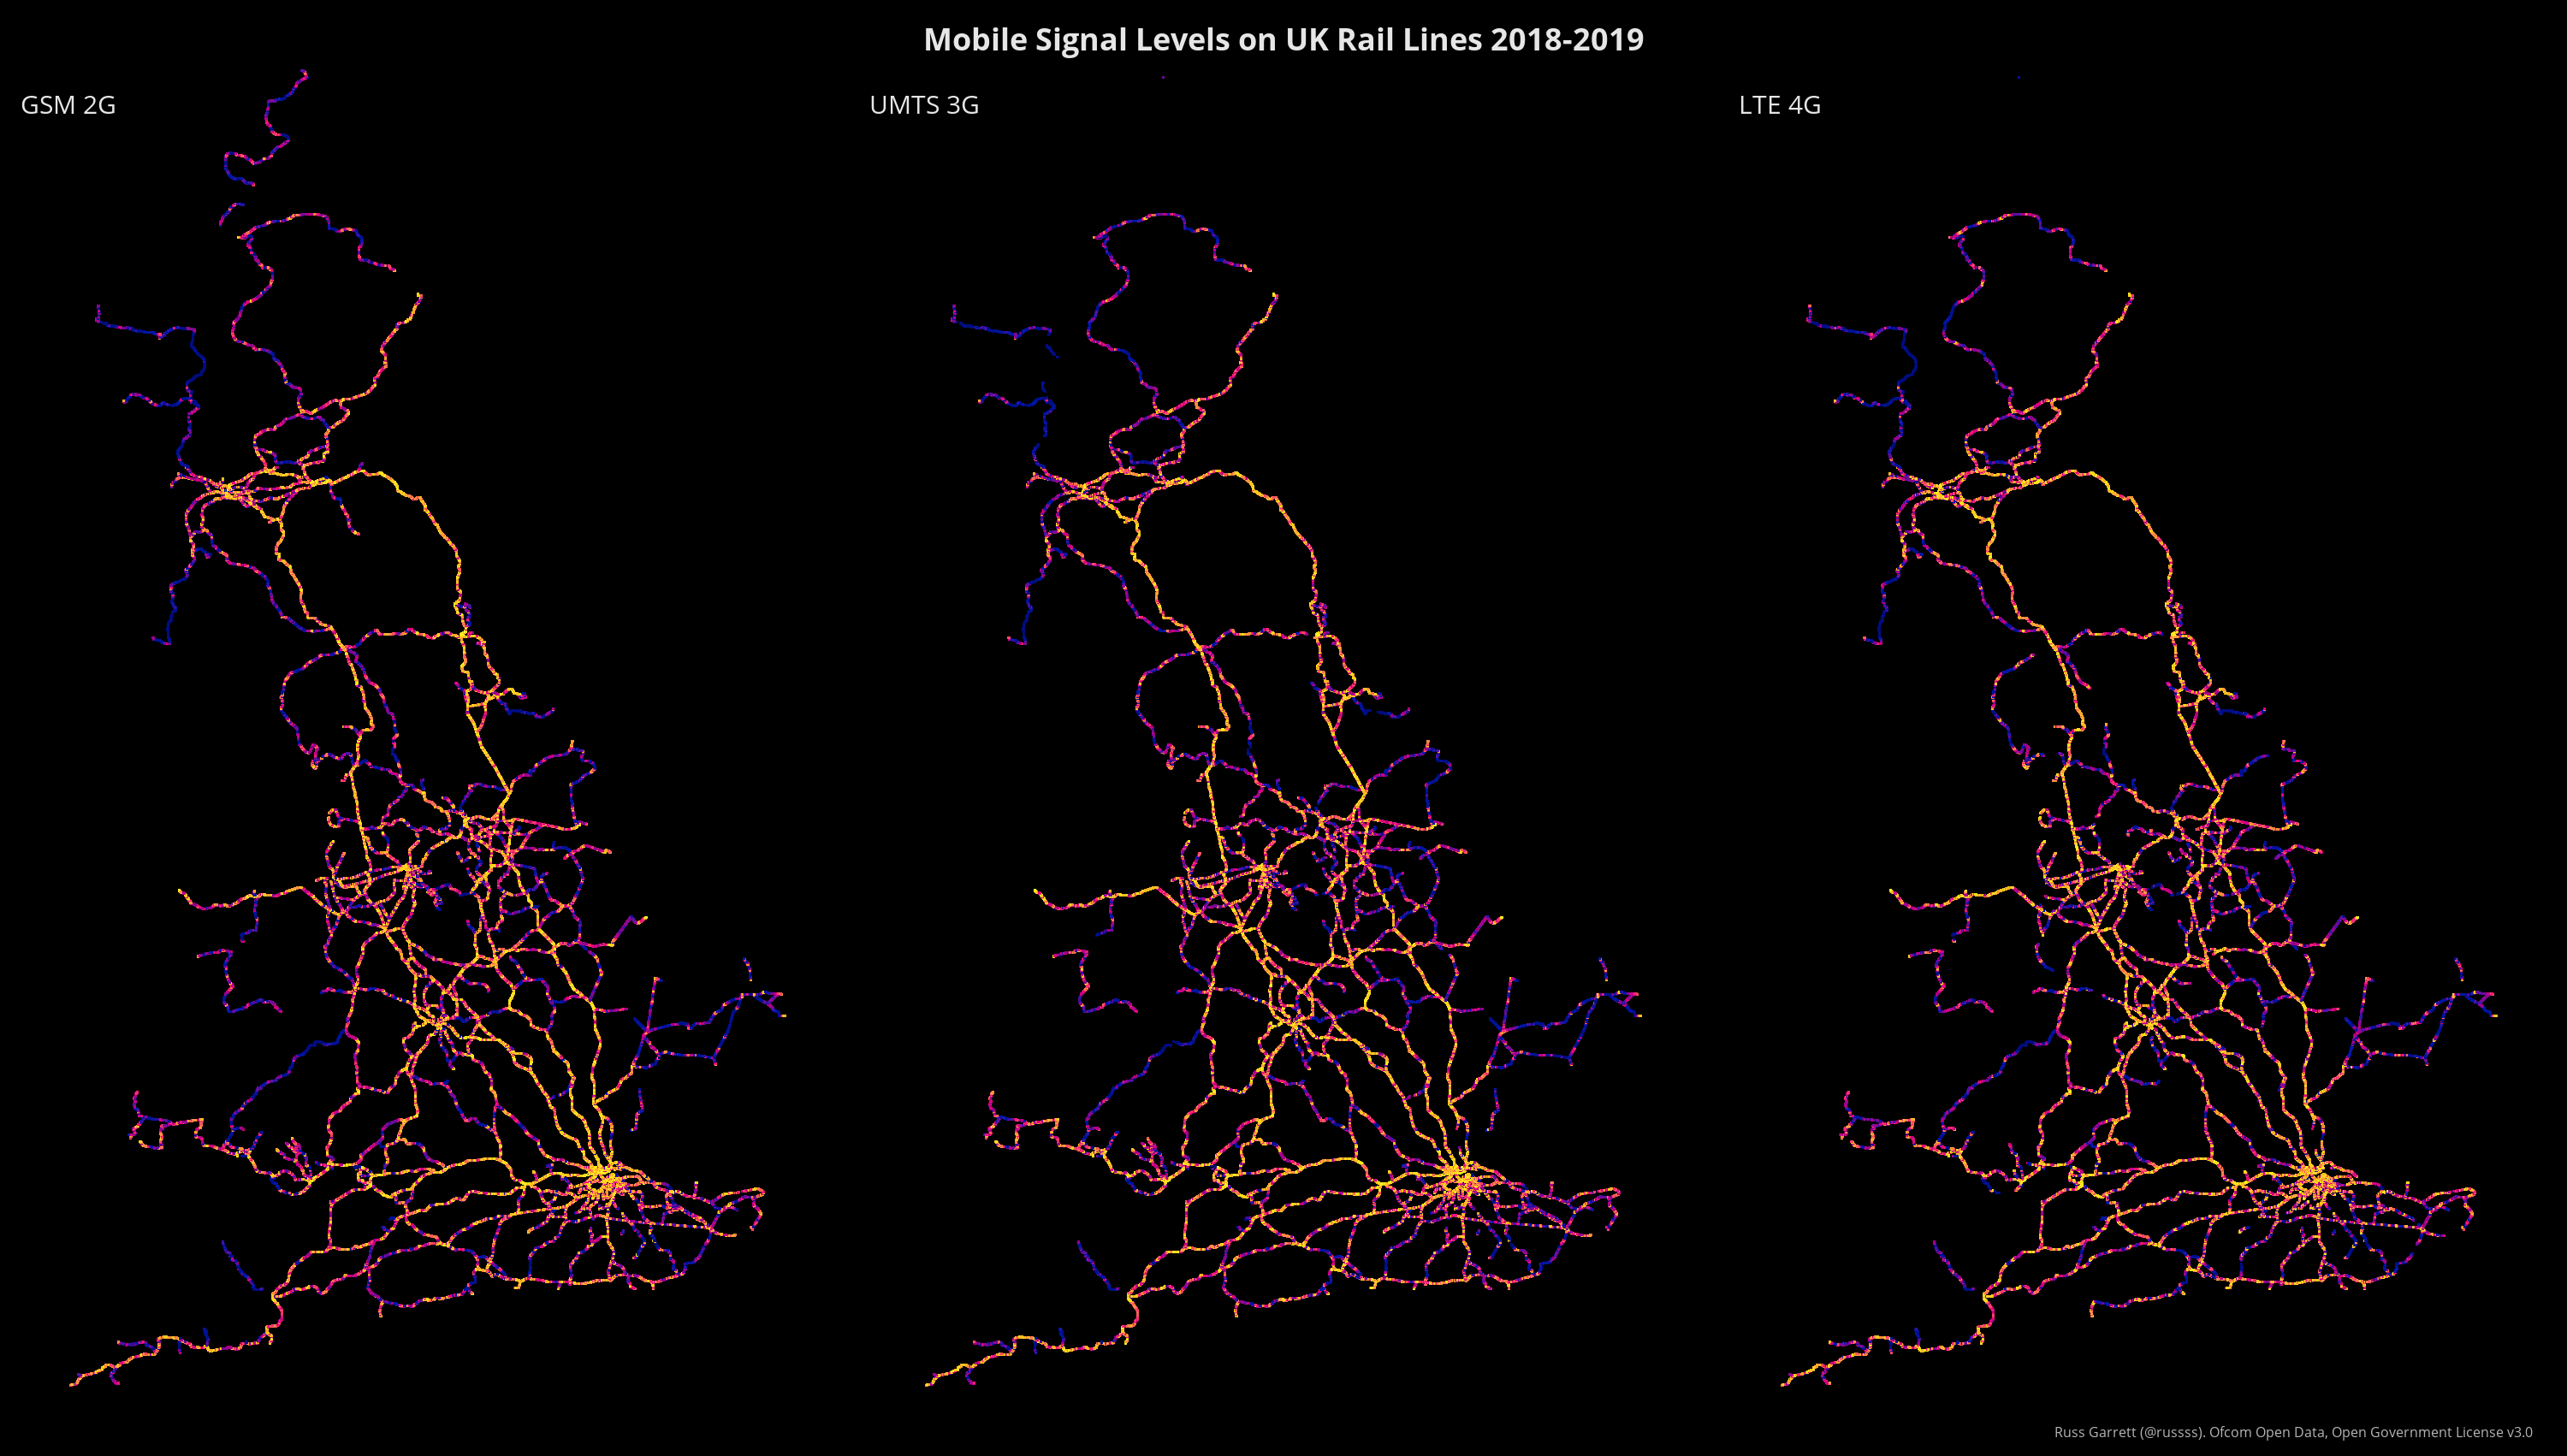

In [10]:
%%time
# Actually render the data.

# Produce the three plot images and label them
images = [draw_text(make_plot(gsm).to_pil(), "GSM 2G", 80, 100), 
          draw_text(make_plot(umts).to_pil(), "UMTS 3G", 80, 100),
          draw_text(make_plot(lte).to_pil(), "LTE 4G", 80, 100)]

# Tile the three images side by side
widths, heights = zip(*(i.size for i in images))
width = sum(widths)
height = max(heights)
output = Image.new('RGB', (width, height))
x_offset = 0
for im in images:
    output.paste(im, (x_offset, 0))
    x_offset += im.size[0]

# Draw title and footer text
draw_text(output, "Mobile Signal Levels on UK Rail Lines 2018-2019", width//2, 20, size=36, face="Bold")
draw_text(output, "Russ Garrett (@russss). Ofcom Open Data, Open Government License v3.0", 
     width - 320, height - 40, size=16, color=(180,180,180))

# Save and render output
output.save('rail_signal_levels.png')
output